In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import datetime
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np


X,y, = load_iris(return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Convert NumPy arrays to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

class IrisNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1  = nn.Linear(4,16)
    self.fc2 = nn.Linear(16,8)
    self.fc3 = nn.Linear(8,3)


  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    return self.fc3(x)

model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
writer = SummaryWriter("logs/iris_torch")
for epoch in range(50):
  optimizer.zero_grad()
  outputs = model(X_train)
  loss = criterion(outputs,y_train)
  loss.backward()
  optimizer.step()
  writer.add_scalar('Loss/train', loss.item(), epoch)
writer.close()
print(y_train)
print("Accuracy: ",(model(X_test).argmax(dim=1) == y_test).float().mean())

tensor([1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0, 2,
        0, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 1,
        2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 2, 1,
        1, 0, 2, 0, 1, 0, 2, 0, 1, 2, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0])
Accuracy:  tensor(0.4667)


In [ ]:
#Preparazione dei dati  MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081)) #Media e deviazione standard
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN,self).__init__()
    self.conv_layers = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3), #1 canale (grigio) -> 32 filtri
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.fc_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,128),
        nn.ReLU(),
        nn.Linear(128,10)
    )
  def forward(self,x):
    x = self.conv_layers(x)
    return self.fc_layers(x)

writer = SummaryWriter(os.path.abspath("logs/mnist_cnn_torch"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def _train_mnist(epochs=2):
  model.train()
  step= 0
  for epoch in range(epochs):
    for batch_idx, (data,target) in enumerate(train_loader):

      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output,target)
      loss.backward()
      optimizer.step()

      if batch_idx % 100 ==0:
        writer.add_scalar('Loss/train', loss.item(),step)
        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).sum() /len(data)
        writer.add_scalar('Accuracy/train', accuracy,step)

        print(f"Epoch: {epoch}[{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss : {loss.item():.6f}")

      step+=1

#Aggiungiamo il grafo del modello a TensorBoard
dummy_input  = torch.zeros(1,1,28,28).to(device)
writer.add_graph(model,dummy_input),
writer.close()


_train_mnist()


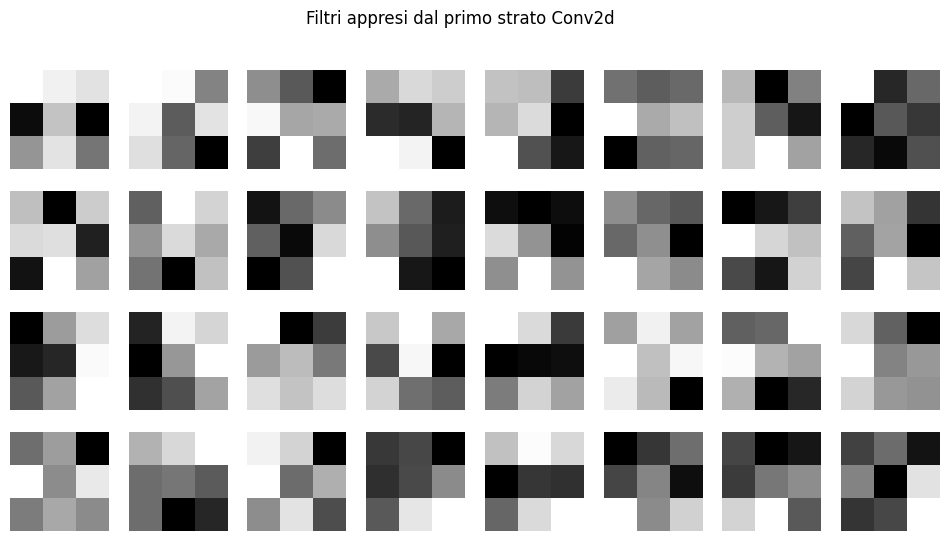

In [16]:

import matplotlib.pyplot as plt

def plot_kernels(models):
  #Estraiamo i pesi del primo strato conv (32 filtri)
  kernels = model.conv_layers[0].weight.detach().cpu()
  fig,axs = plt.subplots(4,8,figsize=(12,6))
  fig.suptitle('Filtri appresi dal primo strato Conv2d')
  for i in range(32):
    row, col = i //8, i % 8
    axs[row, col].imshow(kernels[i][0], cmap='gray')
    axs[row, col].axis('off')
plt.show()
plot_kernels(model)

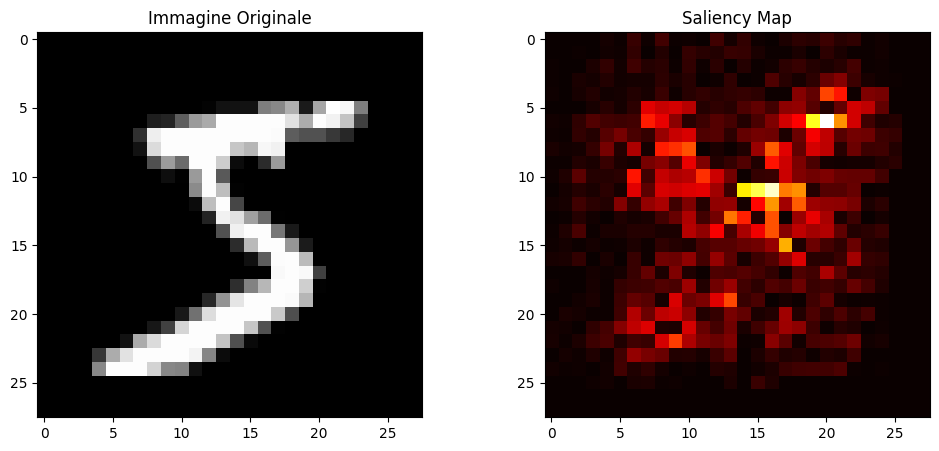

In [19]:
def generate_saliency_map(model, image, label):
  model.eval()
  #1 Abilitiamo il calcolo dei grandi per l'immagine di input
  image.requires_grad_()

  #2. Forward pass
  output = model(image.unsqueeze(0)) #aggiunge dimensione batch
  score = output[0, label]

  #3. backward pass per calcolare il gradiente rispetto all'immagine
  score.backward()

  #4. Il valore assoluto del gradiente rispetto all'immagine
  saliency,_ = torch.max(image.grad.data.abs(),dim=0)

  #5. Visualizzazione
  fig, ax = plt.subplots(1,2,figsize=(12,5))
  ax[0].imshow(image.detach().cpu().numpy()[0], cmap='gray')
  ax[0].set_title('Immagine Originale')

  ax[1].imshow(saliency.cpu().numpy(), cmap='hot')
  ax[1].set_title('Saliency Map')
  plt.show()

#Esempio d'uso
sample_image, sample_label = train_dataset[0]
generate_saliency_map(model,sample_image.to(device),sample_label)